In [1]:
from models import MNISTModel
import time
import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
import random
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
import math

In [64]:
@dataclass 
class ActivationMapHook:
    activation: dict = field(default_factory=dict)
    
    def get_activation(self, name):
        def hook(model, input, output):
            self.activation[name] = output.detach()
        return hook

    def __getitem__(self, idx):
        return self.activation[idx]
    
    def __setitem__(self, idx, new_value):
        self.activation[idx] = new_value

In [2]:
%matplotlib inline

In [3]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [2]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
data_train = torchvision.datasets.MNIST("mnist_data", train=True, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

C:\Users\Giully\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
big_train_ds, small_train_ds, valid_ds = torch.utils.data.random_split(data_train, [45000, 10000, 5000])
# small_train_ds, valid_ds = torch.utils.data.random_split(data_train, [55000, 5000])

In [7]:
test_ds = torchvision.datasets.MNIST("mnist_data", train=False, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [8]:
batch_size = 16
train_dl = DataLoader(small_train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [11]:
model = MNISTModel()
opt = torch.optim.AdamW(model.parameters(), lr=3e-4)
loss_func = torch.nn.NLLLoss()

In [12]:
epochs = 15

def loss_batch(model, loss_func, xb, yb, opt = None):
    y_pred = model(xb)
    loss = loss_func(y_pred, yb)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    return loss.item(), len(xb)


total_time = 0
for epoch in range(epochs):
    since = time.time()

    print(f"Start epoch #{epoch}...")
    
    model.train()
    train_loss = 0       
    
    losses, nums = zip(*[loss_batch(model, loss_func, xb.to(dev), yb.to(dev), opt) 
                        for xb, yb in train_dl])
    train_loss += np.sum(np.multiply(losses, nums)) / np.sum(nums)
    

    info = f"Train_loss: {train_loss}\n"


    model.eval()
    val_loss = 0
    with torch.no_grad():        
        losses, nums = zip(*[loss_batch(model, loss_func, xb.to(dev), yb.to(dev)) for xb, yb in valid_dl])
        val_loss += np.sum(np.multiply(losses, nums)) / np.sum(nums)

    info += f"Valid_loss: {val_loss}\n" 

    time_elapsed = time.time() - since
    total_time += time_elapsed

    
    info += f"Epoch complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s {((time_elapsed % 1) * 1000):.0f}ms\n"
    print(info) 

Start epoch #0...
Train_loss: 1.226931780576706
Valid_loss: 0.45656312322616577
Epoch complete in 0m 6s 67ms

Start epoch #1...
Train_loss: 0.5272654540896415
Valid_loss: 0.29007691100835803
Epoch complete in 0m 5s 228ms

Start epoch #2...
Train_loss: 0.39328001782894134
Valid_loss: 0.2252339083313942
Epoch complete in 0m 5s 525ms

Start epoch #3...
Train_loss: 0.311861070433259
Valid_loss: 0.19329886885285377
Epoch complete in 0m 5s 573ms

Start epoch #4...
Train_loss: 0.26581910811215637
Valid_loss: 0.1602518509939313
Epoch complete in 0m 4s 499ms

Start epoch #5...
Train_loss: 0.23767090827971696
Valid_loss: 0.14793730281963943
Epoch complete in 0m 5s 553ms

Start epoch #6...
Train_loss: 0.21016694739833475
Valid_loss: 0.14196145180910827
Epoch complete in 0m 5s 533ms

Start epoch #7...
Train_loss: 0.19530695740804077
Valid_loss: 0.12156344006508589
Epoch complete in 0m 5s 554ms

Start epoch #8...
Train_loss: 0.17712603775113822
Valid_loss: 0.12508901273310186
Epoch complete in 0m 5

In [ ]:
activation = ActivationMapHook()

model.cnn[0].register_forward_hook(activation.get_activation('cnn[0]'))
model.cnn[1].register_forward_hook(activation.get_activation('cnn[1]'))
data, y = small_train_ds[2]
data.unsqueeze_(0)
output = model(data)

act = activation['cnn[0]'].squeeze()
fig, axarr = plt.subplots(act.size(0) // 4, act.size(0) // 4, figsize=(18, 16), dpi=80)
for i in range(act.size(0) // 4):
    for j in range(4):
        axarr[i, j].imshow(act[i * 4 + j])

In [72]:
r:torch.Tensor = model(data)

In [ ]:
r.backward()

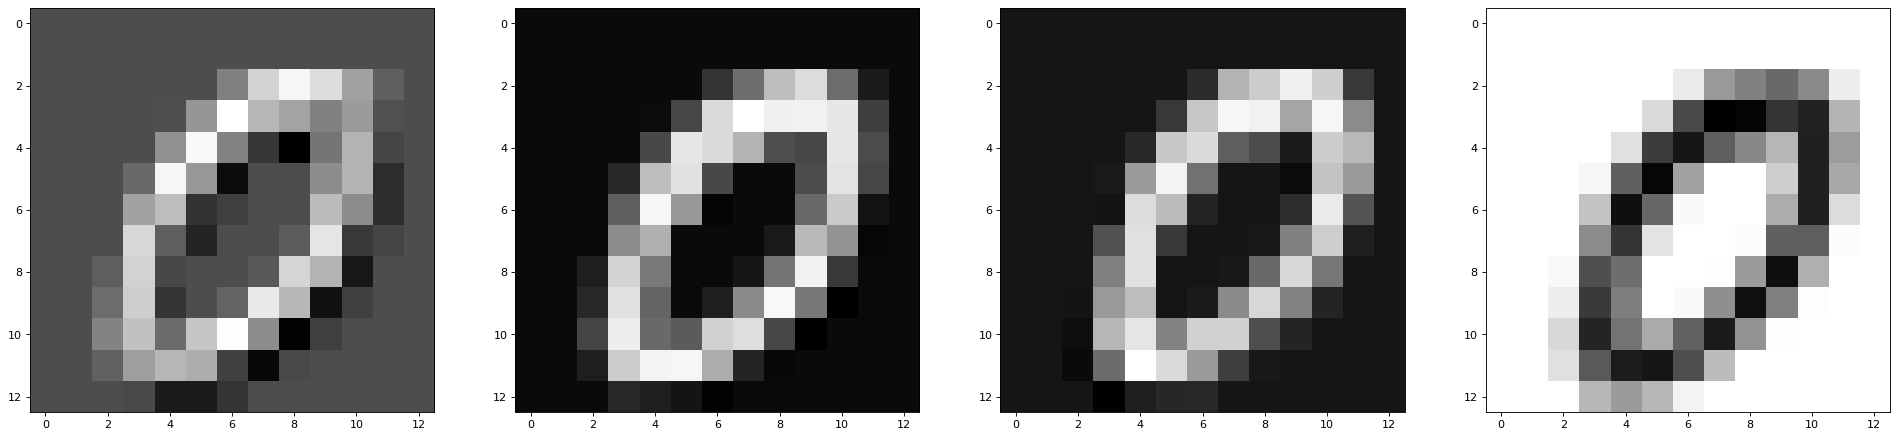

In [80]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook 

model.cnn[0].register_forward_hook(get_activation('cnn[0]'))
data, _ = small_train_ds[2]
data.unsqueeze_(0)
output = model(data)

act = activation['cnn[0]'].squeeze()
n_cols = 4
n_rows = 1
fig, axarr = plt.subplots(n_rows, n_cols, figsize=(30, 30), dpi=80)
for i in range(n_rows):
    for j in range(n_cols):
        axarr[j].imshow(act[i * n_cols + j], cmap='gray')

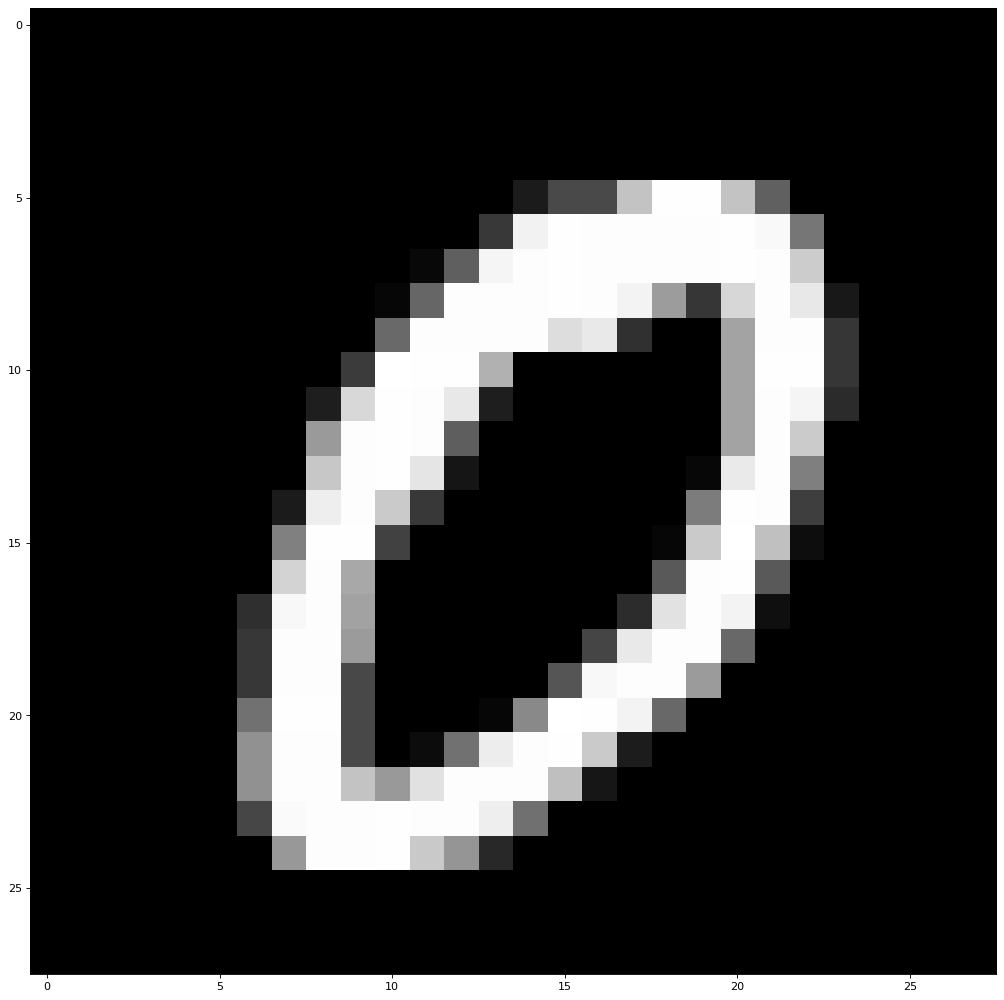

In [62]:
plt.figure(figsize=(18, 16), dpi=80)
plt.imshow(data.squeeze(0).permute(1, 2, 0), cmap='gray')

In [54]:
act.size(0) // n_cols

2

In [59]:
model(data).argmax()

tensor(9)

In [77]:
act[0].shape

torch.Size([13, 13])

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [27]:
filters = model.cnn[2].weight.data.detach()

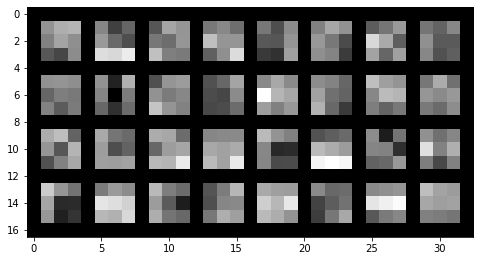

In [28]:
visTensor(filters)

In [15]:
def accuracy(model, test_dl):
    # return (preds == yb).float().mean()
    tot = 0
    correct = 0
    for x, y in test_dl:
        tot += y.shape[0]
        y_pred = model(x)
        preds = torch.argmax(y_pred, dim=1)
        correct += (preds == y).float().sum()
         
    print(f"accuracy: {correct / tot}")

In [16]:
accuracy(model, test_dl)

accuracy: 0.9765999913215637


In [18]:
test_losses = []

def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_dl:
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_dl.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_dl.dataset),
    100. * correct / len(test_dl.dataset)))

In [19]:
test()

C:\Users\Jest\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0317, Accuracy: 9897/10000 (99%)

